# Table of Contents
* [load data](#load-data)
* [process data](#process-data)
	* [bonuses](#bonuses)
	* [frame build](#frame-build)
	* [analysis](#analysis)
	* [building frames](#building-frames)
* [bounding box clustering](#bounding-box-clustering)
* [bonus cost estimate](#bonus-cost-estimate)
* [HTML Review](#HTML-Review)
* [hide](#hide)


In [3]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light default
plt.rcParams['figure.figsize'] = (16.0, 10.0)

import re
import pickle
import boto
from copy import deepcopy
import json
import os
import random
import jinja2
from tqdm import tqdm
from IPython.core.display import HTML

import PIL.Image as Image
import requests

from boto.mturk.qualification import PercentAssignmentsApprovedRequirement, Qualifications, Requirement

from keysTkingdom import mturk_ai2
from keysTkingdom import aws_tokes
from keysTkingdom import mturk_aristo

from amt_utils.mturk import pickle_this, unpickle_this

import os
import jinja2
import argparse
from jinja2 import Environment, FileSystemLoader

j2env = jinja2.Environment()

from amt_utils.bboxes import cluster_from_nms
from amt_utils.bboxes import draw_animation_seq
from amt_utils.bboxes import cluster_from_annos
from amt_utils.bboxes import create_subtask_data
from amt_utils.bboxes import draw_image_and_labels
from amt_utils.bboxes import cluster_and_label
from amt_utils.bboxes import cluster_and_label_stage_1b
from amt_utils.bboxes import cluster_from_nms_stage1_b

import warnings
warnings.filterwarnings('ignore')

# Stage 4b

In [7]:
test_batch_2 = unpickle_this('test_batch_4b_2.pkl')
test_batch_2 = unpickle_this('test4b_2.pkl')

In [563]:
new_4b_assignemnts = unpickle_this('additional_batch_1_4b_update_10_8.pkl')

In [280]:
full_batch_2 = unpickle_this('full_batch_2_update.pkl')

In [282]:
test_batch_2_results =[]
for assignment_triple in full_batch_2.values():
    if len(assignment_triple) > 2:
        test_batch_2_results.extend(assignment_triple)

# process data

In [283]:
def create_result(assmt):
    result = json.loads(assmt.answers[0][0].fields[0])
    result['h_id'] = assmt.HITId
    result['a_id'] = assmt.AssignmentId 
    result['worker_id'] = assmt.WorkerId
    return result

In [284]:
test_2_results = [create_result(ar) for ar in test_batch_2_results]
objects_present = [{'h_id': anno['h_id'], 'w_id': anno['worker_id'], 'still_id': anno['stillID'], 'objects': set([ch['label'] for ch in json.loads(anno['characterBoxes'])])} for anno in test_2_results]

In [105]:
s4b_df = pd.DataFrame(objects_present)
s4b_df['aid'] = s4b_df['still_id'].apply(lambda x: x.rsplit('_', 1)[0])

In [106]:
assignment_results = test_2_results
annotations_by_frame = defaultdict(list)
for anno in sorted(assignment_results, key=lambda x: x['stillID']):
    animation_id = anno['stillID']
    annotations_by_frame[animation_id].append(anno)

In [110]:
len(annotations_by_frame)

1176

# analysis

In [949]:
bbox_df = pd.DataFrame(characters_boxes)

In [950]:
bbox_df['bbox'] = bbox_df['raw_bbox'].apply(lambda z: characterbox_to_box(next(iter(sorted(z, key= lambda x: x['left']) or []), {"left":0,"top":0,"width":0,"height":0})))

In [33]:
def choose_frame(bbox):
    if bbox[0] < 640:
        return '_10.png'
    else:        
        return '_70.png'

In [112]:
bbox_df['frame_n'] = bbox_df['bbox'].apply(lambda x: choose_frame(x))

NameError: name 'bbox_df' is not defined

In [31]:
def assign_con_box(row):
    first_frame = row['frame_n'] == '_10.png'
    aid = row['still_id'][:-10]
    if aid in subtask_consensus_boxes:
        con_box_choices = subtask_consensus_boxes[aid]
    else:
        return([0, 0, 0, 0])
    for box in con_box_choices:
        if box['label'] in row['characters']:
            if box['box'][0] < 640 and first_frame:
                return box['box'].tolist()
            if box['box'][0] > 640 and not first_frame:
                return box['box'].tolist()
    return([1, 0, 0, 0])

In [954]:
# subtask_consensus_boxes['s_02_e_21_shot_020348_020422']

In [955]:
 bbox_df.head(1).apply(assign_con_box, axis=1)

0    [293, 90, 431, 480]
dtype: object

In [956]:
bbox_df['con_box'] = bbox_df.apply(assign_con_box, axis=1)

In [139]:
subtask_by_frame = defaultdict(list)
for anno in sorted(subtask_results, key=lambda x: x['stillID']):
    animation_id = anno['stillID'].rsplit('_', 1)[0]
    subtask_by_frame[animation_id].append(anno)

In [75]:
rev_dir = 'review_results'
img_dir = 'review_frames'

In [76]:
char_change = defaultdict(list)
for aid, annos in list(subtask_by_frame.items()):
    disapear_count = 0
    for anno in annos:
        la = json.loads(anno['characterBoxes'])
        if len(la) !=2:
            disapear_count += 1
    if disapear_count == 3:
        char_change[aid].append(la)

In [77]:
list(char_change.items())[0]

('s_01_e_01_shot_014223_014297',
 [[{'height': 371,
    'label': 's_01_e_01_shot_014223_014297_char_0_taskb.png',
    'left': 672,
    'top': 101,
    'width': 244}]])

In [47]:
1108/ len(subtask_by_frame)

0.059387897303960976

In [44]:
len(char_change)

1108

In [126]:
task_r_lengths = pd.Series([len(sta) for sta in list(subtask_by_frame.values())])

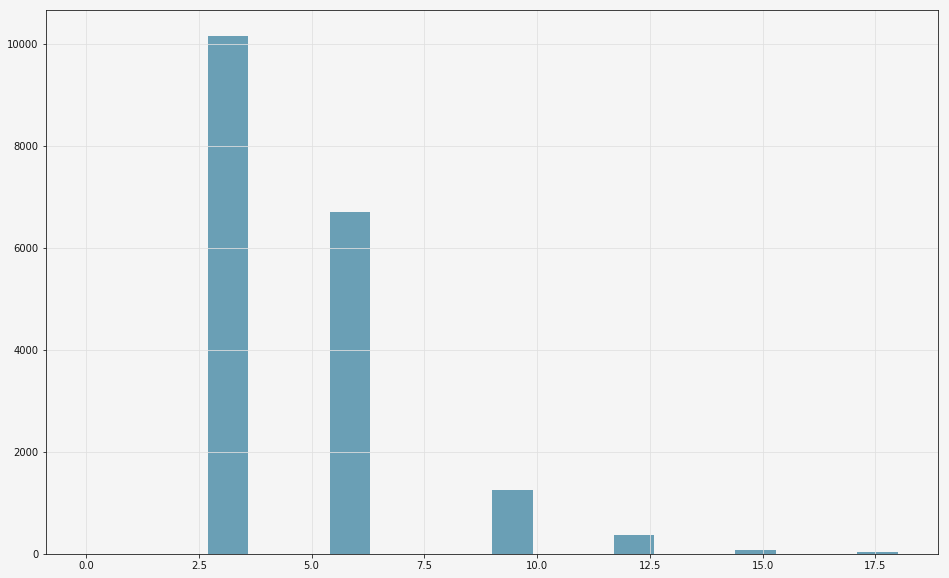

In [130]:
task_r_lengths[task_r_lengths < 20].hist(bins=20)

In [18]:
subtask_rev_seq = []
stage_1b_consensus_boxes = {}
for aid, animation_annos in tqdm(list(subtask_by_frame.items())[:51]):
    try:
        middle_frame_annos = annotations_by_frame[aid][3:6]
        full_original_annos = annotations_by_frame[aid]
        two_frame_image, con_boxes, labels = draw_image_and_labels(animation_annos, cluster_from_nms, 1, 3, './subtask_data/frames/')
        three_frame_img, consensus_boxes, labels_orig = draw_animation_seq(full_original_annos, cluster_from_nms)
        single_frame_image, single_con_boxes, labels = draw_image_and_labels(middle_frame_annos, cluster_from_nms, 1, 3)
        left_image = two_frame_image.crop(frame_origin + frame_size)
        right_image = two_frame_image.crop(frame_o2 + frame_ext)
        imgs_comb = Image.fromarray(np.hstack([left_image, single_frame_image, right_image]))
        o_img_path = os.path.join(img_dir, aid) + '_rev.png'
        new_img_path = os.path.join(img_dir, aid) + 'subtask_rev.png'
        three_frame_img.save(os.path.join(rev_dir, o_img_path))
        imgs_comb.save(os.path.join(rev_dir, new_img_path))
        subtask_rev_seq.append((aid, o_img_path, new_img_path))
    except:
        print(aid)

In [121]:
frame_origin = (0, 0)
frame_size = (640, 480)
frame_o2 = (640, 0)
frame_ext = (1280, 480)

In [143]:
len(subtask_by_frame)

18700

# compute consensus

In [122]:
problem_vid = 's_01_e_01_shot_008499_008573'

In [156]:
json.loads(annotations_by_frame[problem_vid][0]['characterBoxes'])

[{'height': 231, 'label': 'hammock_0_5', 'left': 2, 'top': 143, 'width': 636},
 {'height': 247,
  'label': 'hammock_0_5',
  'left': 642,
  'top': 140,
  'width': 634},
 {'height': 233,
  'label': 'hammock_0_5',
  'left': 1282,
  'top': 138,
  'width': 630}]

In [498]:
from amt_utils.bboxes import draw_object_seq
from amt_utils.bboxes import comp_box_center
from amt_utils.bboxes import comp_boxes_iou
from amt_utils.bboxes import characterbox_to_box
from amt_utils.bboxes import rect_from_anno
from amt_utils.bboxes import box_area
from amt_utils.bboxes import is_duplicate
from amt_utils.bboxes import filter_keep_by_area_fraction
from amt_utils.bboxes import assign_boxes
from amt_utils.bboxes import box_area

In [499]:
def assign_frame(box):
    frame_width = 640
    box_center = comp_box_center(box)
    return int(box_center[0] // frame_width)

In [500]:
def choose_best_box(obj_boxes, thresh=0.05):
    for i, b1 in enumerate(obj_boxes):
        for j in range(i + 1, len(obj_boxes)):
            b2 = obj_boxes[j]
            print(b1, b2, comp_boxes_iou(b1['box'], b2['box']))
            if comp_boxes_iou(b1['box'], b2['box']) > thresh:
                print('true')
#                 return b1
    return obj_boxes[0]

In [501]:
def nms(boxes, thresh):
    boxes = sorted(boxes, key=lambda x: x['area'], reverse=True)  # largest area first
    keep = [None] * len(boxes)
    for i, box in enumerate(boxes):
        keep[i] = not is_duplicate(i, boxes, thresh)
    # print(keep)
    filter_keep_by_area_fraction(boxes, keep, thresh)
    # print(keep)
    selected_boxes = [boxes[i] for i in range(len(boxes)) if keep[i]]
    duplicate_boxes = [boxes[i] for i in range(len(boxes)) if not keep[i]]
    assign_boxes(selected_boxes, duplicate_boxes)
    for b1 in selected_boxes:
        idx = b1['idx']
        votes = 1
        for b2 in duplicate_boxes:
            if b2['duplicate_of'] == idx:
                votes += 1

        b1['votes'] = votes
    if not duplicate_boxes:
        duplicate_boxes = []
    filtered_boxes = [box for box in selected_boxes if box['votes'] > 1]
    return filtered_boxes

In [504]:
con_boxes = choose_object_boxes(annotations_by_frame['s_05_e_23_shot_028963_029037'])

In [505]:
def enclosing_box(boxes):
    rects = np.array([box['box'] for box in boxes])
    lower = rects[:,0:2].min(axis=0)
    upper = rects[:,2:].max(axis=0)
    enclosing_rect = np.concatenate([lower, upper])
    new_box = {
        'box': enclosing_rect,
        'area': box_area(enclosing_rect.reshape(2, 2)),
        'label': boxes[0]['label'],
        'idx': 0,
        'frame': boxes[0]['frame']
    }
    return new_box

In [506]:
rl1 = enclosing_box(test_boxes)

In [507]:
# lower.min(axis=0)

In [508]:
def choose_best_box(obj_boxes):
    print(obj_boxes, '\n')
    return obj_boxes[1]

In [554]:
def choose_object_boxes(object_annotations):
    single_turker_boxes = [json.loads(box['characterBoxes']) for box in object_annotations]
    single_turker_boxes = [b for sl in single_turker_boxes for b in sl ]
    boxes = [None] * len(single_turker_boxes)
    for i, charBox in enumerate(single_turker_boxes):
        box = characterbox_to_box(charBox)
        area = charBox['width'] * charBox['height']
        label = charBox['label']
        boxes[i] = {
            'box': box,
            'area': area,
            'label': label,
            'idx': i,
            'frame': assign_frame(box)
        }
    boxes = sorted(boxes, key=lambda x: x['area'])
    boxex_by_label = defaultdict(lambda : defaultdict(list))
    for box in boxes:
        if box['area'] < 100:
            continue
        boxex_by_label[box['label']][box['frame']].append(box)
    con_boxes = []
    for obj, frames_boxes in boxex_by_label.items():
        for frame_n, boxes in frames_boxes.items():
#             con_boxes.append(enclosing_box(boxes))
            con_box = nms(boxes, 0.2)
            if con_box:
                if len(con_box) < 2:
                    con_boxes.append(con_box[0])
                else:
                    con_boxes.append(enclosing_box(con_box))
            else:
                con_boxes.append(enclosing_box(boxes))
    return con_boxes

In [555]:
con_boxes = choose_object_boxes(annotations_by_frame['s_01_e_01_shot_008499_008573'])

In [556]:
con_boxes

[{'area': 13333,
  'box': array([789, 143, 988, 210]),
  'frame': 1,
  'idx': 0,
  'label': 'hands_1_7'},
 {'area': 15147,
  'box': array([1430,  110, 1617,  191]),
  'frame': 2,
  'idx': 0,
  'label': 'hands_1_7'},
 {'area': 137788,
  'box': array([1284,  125, 1816,  384]),
  'frame': 2,
  'idx': 5,
  'label': 'hammock_0_5',
  'votes': 3},
 {'area': 142240,
  'box': array([ 640,  141, 1275,  365]),
  'frame': 1,
  'idx': 7,
  'label': 'hammock_0_5',
  'votes': 3},
 {'area': 142650,
  'box': array([  2, 140, 636, 365]),
  'frame': 0,
  'idx': 6,
  'label': 'hammock_0_5',
  'votes': 3}]

In [557]:
# annotations_by_frame['s_01_e_01_shot_008499_008573']

In [558]:
# choose_object_boxes(test_obj_anno)

In [559]:
subtask_consensus_boxes = {}
for aid, animation_annos in tqdm(list(annotations_by_frame.items())):
    con_boxes = choose_object_boxes(animation_annos)
    subtask_consensus_boxes[aid] = con_boxes

100%|██████████| 1176/1176 [00:00<00:00, 1218.10it/s]


In [560]:
pickle_this(subtask_consensus_boxes, 'stage_4b_con_batch_2_new_method.pkl')

In [561]:
# for vid in list(subtask_consensus_boxes.values()):
#     for box in vid:
#         if 'label' not in box.keys():
#             print(box)

In [315]:
# con_boxes

### worker investigation

In [1079]:
# animation_annos

In [192]:
from amt_utils.bboxes import characterbox_to_box
from amt_utils.bboxes import comp_boxes_iou

In [194]:
worker_con_record = defaultdict(list)

In [230]:
def proc_anno(anno, con_boxes):
    char_boxes = sorted([characterbox_to_box(box) for box in json.loads(anno['characterBoxes'])], key=lambda x: x[0])
    if len(con_boxes) < 2:
        return 'noncon', 1
    if len(char_boxes) < 2:
        return anno['worker_id'], 0
    box_1_iou = comp_boxes_iou(con_boxes[0]['box'], char_boxes[0])
    box_2_iou = comp_boxes_iou(con_boxes[1]['box'], char_boxes[1])
    return anno['worker_id'], (box_1_iou + box_2_iou) / 2

def proc_frame(frame_id, worker_con_record):
    cons_boxes = subtask_consensus_boxes[frame_id]
    for anno in subtask_by_frame[frame_id]:
        wid, con_iou = proc_anno(anno, cons_boxes)
        worker_con_record[wid].append(con_iou)

In [231]:
len(subtask_by_frame)

18700

In [998]:
grouped_by_still = bbox_df.groupby('still_id')

In [239]:
worker_con_ious = defaultdict(list)

for frame in list(subtask_consensus_boxes):
    proc_frame(frame, worker_con_ious)

In [263]:
worker_avg_oius = pd.Series(worker_con_ious).apply(lambda x: np.mean(x))
worker_counts = pd.Series(worker_con_ious).apply(lambda x: len(x))
prolific_ious = pd.Series({k:v for k,v in worker_con_ious.items() if k in prolific_workers}).apply(lambda x: np.mean(x))

In [264]:
prolific_ious.sort_values(ascending=False)

A3N76F2ZPQETH5    0.259235
A1RU9BQLDZ1DSY    0.255615
A2VI8XH6A1PB27    0.253130
A2PU4YNWITAQVL    0.252389
A2BG0A5HKVT2KD    0.245400
AH4SMMFHDHK1L     0.241663
A11NUW5OVADGYU    0.240351
ACWBK5ISFR2B2     0.238748
A2X7BE2FSPUKCK    0.231727
A24NA8ASZY358P    0.230231
A15DOG6AXQ7LGY    0.227798
A3R6KO03P9QLNO    0.222626
A273GB71FE8RIV    0.219026
A2CXEAMWU2SFV3    0.204082
A9ALF1SODWQE5     0.195207
A3UPV16IECELHV    0.184253
A3G2NE6QE5W5R     0.179639
A3HDMR3ZFQVT7B    0.165927
A3662J93B79L3J    0.132862
dtype: float64

In [582]:
prolific_workers = set(worker_counts.sort_values(ascending=False)[:100].index)
prolific_workers.remove('noncon')

In [190]:
proc_anno(subtask_by_frame['s_01_e_01_shot_004169_004243'][0], con_boxes)

('A1RO22O88I71FD', 0.63129791710397876)

In [ ]:
proc_frame(subtask_by_frame['s_01_e_01_shot_004169_004243'])

In [80]:
pickle_this(subtask_consensus_boxes, 'processed_subtask_boxes.pkl')

In [105]:
len(json.loads(subtask_by_frame['s_02_e_07_shot_010402_010476'][0]['characterBoxes']))

8

In [44]:
page_html = generate_subtask_review(subtask_rev_seq)

In [100]:
len(subtask_by_frame)

1632

In [48]:
# with open('complete_subtask_clips.txt', 'a') as f:
#     import csv
#     cw = csv.writer(f, delimiter=' ')
#     cw.writerow(list(subtask_by_frame.keys()))

In [272]:
tfid, annos = list(subtask_by_frame.items())[0]

In [275]:
annos[0]['characterBoxes']

'[{"left":151,"top":80,"width":268,"height":359,"label":"s_01_e_01_shot_000099_000173_char_0_taskb.png"},{"left":791,"top":89,"width":265,"height":350,"label":"s_01_e_01_shot_000099_000173_char_0_taskb.png"}]'

In [296]:
wbox = characterbox_to_box(json.loads(annos[0]['characterBoxes'])[0]).reshape(2, 2)
cbox = characterbox_to_box(json.loads(annos[1]['characterBoxes'])[0]).reshape(2, 2)

In [512]:
bbox_df.head(1)

,characters,h_id,raw_bbox,still_id,w_id,bbox,frame_n,con_box
0,{s_02_e_21_shot_020348_020422_char_2_taskb.png},301KG0KX9DLGOXDCQAV6YDE1ARFH2Q,"[{'left': 930, 'top': 98, 'width': 145, 'heigh...",s_02_e_21_shot_020348_020422_taskb.png,A1PWETOH9I7CRJ,"[291, 98, 437, 479]",_10.png,"[293, 90, 431, 480]"


In [554]:
def comp_row_iou(row):
    return comp_boxes_iou(row['bbox'], np.array(row['con_box']))

In [957]:
bbox_df_con_exists = bbox_df[bbox_df['con_box'].apply(lambda x: sum(x) > 2)]

In [958]:
bbox_df_con_exists['con_iou'] = bbox_df_con_exists.apply(comp_row_iou, axis=1)

In [959]:
grouped_by_worker = bbox_df_con_exists.groupby('w_id')

In [960]:
workers_below_thresh = grouped_by_worker.agg(np.mean) < 0.65

In [962]:
workers_below_thresh = workers_below_thresh.reset_index()

In [963]:
suspect_workers = workers_below_thresh[workers_below_thresh['con_iou']]

In [964]:
check_these_workers = suspect_workers[suspect_workers['w_id'].isin(prolific_workers)]['w_id'].values.tolist()

In [965]:
prolific_worker_df = bbox_df[bbox_df['w_id'].isin(prolific_workers)]

In [966]:
check_these_workers

['A1FL6CA4FMJ3KB',
 'A1HA4T6P2CM2WV',
 'A1J8Y204VZNWQW',
 'A1RO22O88I71FD',
 'A2CXEAMWU2SFV3',
 'A2PU4YNWITAQVL',
 'A303MN1VOKQG5I',
 'A3662J93B79L3J']

In [989]:
len(check_these_workers)

8

In [920]:
worker_bans = ['A1HA4T6P2CM2WV']
ban_below_thresh = ['A1J8Y204VZNWQW', 'A1RO22O88I71FD', 'A303MN1VOKQG5I', 'A3662J93B79L3J']

In [967]:
assignments_to_reject = set(bbox_df[bbox_df['w_id'].isin(worker_bans)]['a_id'].tolist())

In [982]:
bbox_df_sel_rej = bbox_df_con_exists[bbox_df_con_exists['w_id'].isin(ban_below_thresh)]
assignments_to_reject.update(set(bbox_df_sel_rej[bbox_df_sel_rej['con_iou'] < 0.65]['a_id'].tolist()))

In [987]:
subtask_workers_to_ban = set(worker_bans + ban_below_thresh)
pickle_this(subtask_workers_to_ban, 'subtask_workers_to_ban.pkl')

In [988]:
pickle_this(assignments_to_reject, 'subtask_aids_to_reject.pkl')

In [985]:
len(assignments_to_reject)

2133

In [921]:
prolific_worker_df_con_exists = prolific_worker_df[prolific_worker_df['con_box'].apply(lambda x: sum(x) > 2)]

In [970]:
check_df = bbox_df_con_exists[bbox_df_con_exists['w_id'] == check_these_workers[7]]
subn = check_df.shape[0]
subn

1245

In [971]:
rown = random.randint(0, subn)
worker_row = check_df.iloc[rown: rown+1]
worker_row

,a_id,characters,h_id,raw_bbox,still_id,w_id,bbox,frame_n,con_box,con_iou
10676,3IHR8NYAM81LRCOH33R1PL8B2NBP45,{s_02_e_03_shot_029458_029532_char_0_taskb.png},311HQEI8RTG91JAC28I8UBZEHXJZ7F,"[{'left': 222, 'top': 119, 'width': 116, 'heig...",s_02_e_03_shot_029458_029532_taskb.png,A3662J93B79L3J,"[222, 119, 338, 248]",_10.png,"[183, 89, 406, 416]",0.205208


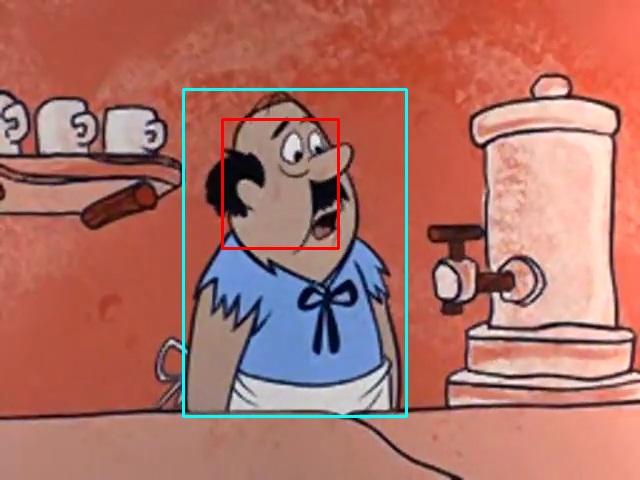

In [972]:
worker_row.apply(draw_row, axis=1).item()

In [813]:
# draw_clusters(tfid, wbox, cbox)

In [510]:
def draw_row(row):
    aid = row['still_id'][:-10]
    return draw_clusters(aid, row['bbox'].reshape(2, 2), np.array(row['con_box']).reshape(2, 2))

def draw_clusters(img_id, worker_box, consensus_box, color=(0, 255, 255)):
    image_base_dir = '/Users/sachwenk/wrk/animation_gan/build_dataset/Flintstone_Shots_Selected_Frames/'
    img_path = image_base_dir + img_id + '_10.png'
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    max_height, max_width, channels = image.shape
#     limit_rect(worker_box, max_width, max_height)
    cv2.rectangle(image, tuple(worker_box[0]), tuple(worker_box[1]), color=(255, 0, 0), thickness=2)
    cv2.rectangle(image, tuple(consensus_box[0]), tuple(consensus_box[1]), color=color, thickness=2)
    return Image.fromarray(image)

# bounding box clustering

In [154]:
from amt_utils.bboxes import draw_object_seq
from amt_utils.bboxes import comp_box_center
from amt_utils.bboxes import characterbox_to_box

In [ ]:
rev_dir = 'review_results'
img_dir = 'review_frames'

In [142]:
# con_boxes, labels = cluster_and_label_stage_1b(animation_annos, cluster_from_nms_stage1_b, 1, 3, './subtask_data/frames/')

In [159]:
test_obj_anno = annotations_by_frame[problem_vid]

In [241]:
problem_vid

's_01_e_01_shot_008499_008573'

In [139]:
three_frame_img, consensus_boxes, labels = draw_object_seq(annotations_by_frame[problem_vid], cluster_from_nms_stage1_b)

NameError: name 'single_still_annos' is not defined

In [131]:
review_seq = {}
error_frames = []
for aid, animation_annos in tqdm(list(annotations_by_frame.items())[:2]):
    try:
        three_frame_img, consensus_boxes, labels = draw_animation_seq(animation_annos, cluster_from_nms_stage1_b)
        avg_votes = np.mean([box['votes'] for frame in consensus_boxes for box in frame])
        possible_labels = [c['possible_labels'] for c in sorted(labels, key=lambda x: x['box'][0])]
        chosen_labels = [c['chosen_labels'] for c in sorted(labels, key=lambda x: x['box'][0])]
        review_seq[aid] = {'votes': avg_votes, 'possible_labels': possible_labels, 'chosen_labels': chosen_labels}
        img_path = os.path.join(rev_dir, img_dir, aid) + '_rev.png'
        three_frame_img.save(img_path)
    except IndentationError:
        error_frames.append(aid)
rev_page = generate_review_page('bbox_review_10_3.html')

  0%|          | 0/2 [00:00<?, ?it/s]

['stillID', 'characterBoxes', 'h_id', 'a_id', 'worker_id', 'stillID', 'characterBoxes', 'h_id', 'a_id', 'worker_id', 'stillID', 'characterBoxes', 'h_id', 'a_id', 'worker_id']


TypeError: string indices must be integers

In [127]:
three_frame_img, consensus_boxes, labels = draw_animation_seq(annotations_by_frame[problem_vid], cluster_from_nms)
avg_votes = np.mean([box['votes'] for frame in consensus_boxes for box in frame])
possible_labels = [c['possible_labels'] for c in sorted(labels, key=lambda x: x['box'][0])]
chosen_labels = [c['chosen_labels'] for c in sorted(labels, key=lambda x: x['box'][0])]
review_seq[aid] = {'votes': avg_votes, 'possible_labels': possible_labels, 'chosen_labels': chosen_labels}
three_frame_img

## debug

In [ ]:
# review_seq = {}
# error_frames = []
# n = 0
# for aid, animation_annos in list(debug_sample.items()):
#     three_frame_img, consensus_boxes = draw_animation_seq(animation_annos, cluster_from_nms)
#     avg_votes = np.mean([box['votes'] for frame in consensus_boxes for box in frame])
#     possible_labels = [c['possible_labels'] for c in sorted(labels, key=lambda x: x['box'][0])]
#     chosen_labels = [c['chosen_labels'] for c in sorted(labels, key=lambda x: x['box'][0])]
#     review_seq[aid] = {'votes': avg_votes, 'possible_labels': possible_labels, 'chosen_labels': chosen_labels}
#     img_path = os.path.join(rev_dir, img_dir, aid) + '_rev.png'
#     three_frame_img.save(img_path)
# #     except IndexError:
# #         error_frames.append(aid)

# rev_page = generate_review_page('bbox_review_new_8_7_debug.html')
# rev_page = rev_page.replace('review_frames', 'review_results/review_frames').replace('.png', '.png?arg' + str(random.randint(0, 100000000)))
# HTML(rev_page)

In [29]:
debug_clips = ['s_01_e_06_shot_020535_020609', 's_01_e_05_shot_009896_009970', 's_01_e_06_shot_025311_025385', 's_01_e_07_shot_014729_014803', 's_01_e_06_shot_032983_033057']
debug_clips = ['s_01_e_04_shot_016588_016662', 's_01_e_05_shot_009896_009970', 's_01_e_06_shot_020535_020609', 's_01_e_01_shot_022792_022866']
debug_clips = ['s_01_e_06_shot_020535_020609']
debug_clips += ['s_01_e_01_shot_022792_022866']
debug_clips += ['s_01_e_05_shot_002673_002747']
debug_clips += ['s_01_e_06_shot_007192_007266']
debug_clips += ['s_01_e_05_shot_004222_004296']

debug_sample = {debug_clip: annotations_by_frame[debug_clip] for debug_clip in debug_clips}

In [30]:
error_clip = list(annotations_by_frame.values())[0]

three_frames = [s3_base_path + error_clip[i]['stillID'] for i in [0, 6]]
imgs_comb = np.hstack([Image.open(requests.get(image_url, stream=True).raw) for image_url in three_frames])
test_image = Image.fromarray(imgs_comb)

In [26]:
test_image.size

NameError: name 'test_image' is not defined

In [91]:
annotations_by_frame['s_01_e_19_shot_025542_025616']

NameError: name 'annotations_by_frame' is not defined

# bonus cost estimate

In [197]:
main_characters = [
    "Fred",
    "Wilma",
    "Mr Slate",
    "Barney",
    "Betty",
    "Pebbles",
    "Dino",
    "Baby Puss",
    "Hoppy",
    "Bamm Bamm",
]

empty_characters = ['no characters', 'empty frame']
main_characters += empty_characters
main_characters = [char.lower() for char in main_characters]

In [183]:
frame_cost = 0
bonus_cost = 0
for anno in list(review_seq.values()):
    frame_cost += 0.05 * 3
#     print(anno)
    bonus_cost += len([char for char in anno['chosen_labels'] if char not in main_characters]) * 0.03

In [184]:
print(frame_cost, bonus_cost)
frame_cost + bonus_cost

80.25000000000018 3.659999999999995


83.91000000000018

In [200]:
frame_count = []
for anno in list(review_seq.values()):
    frame_count += len([char for char in anno['chosen_labels'] if char not in empty_characters])

In [201]:
frame_count

787

# HTML Review

In [71]:
review_page_html = """
<!DOCTYPE html>
<html>
  <head>
    <style type="text/css">
       .container {
          }
    </style>
  </head>
  <body style=max-width: 100px>
    <div class="container">
      <ul>
        {% for clip in clips %}
        <h2>clip: {{clip[0]}}</h2>
        <h3>score: {{clip[2]}}      rank: {{clip[3]}}</h3>
        <p>{{clip[1]}}</p>
        <p>{{clip[4]}}</p>
        <p>{{clip[5]}}</p>
        {% endfor %}
      </ul>
    </div>
    <script src="http://code.jquery.com/jquery-1.10.2.min.js"></script>
    <script src="http://netdna.bootstrapcdn.com/bootstrap/3.0.0/js/bootstrap.min.js"></script>
  </body>
</html>
"""


review_subtask_comp = """
<!DOCTYPE html>
<html>
  <head>
    <style type="text/css">
       .container {
          }
    </style>
  </head>
  <body style=max-width: 100px>
    <div class="container">
      <ul>
        {% for clip in clips %}
        <h2>clip: {{clip[0]}}</h2>
        <h4>original 3 frames:</h4>
        <p>{{clip[1]}}</p>
        <h4>new frames + original middle:</h4>
        <p>{{clip[2]}}</p>
        {% endfor %}
      </ul>
    </div>
    <script src="http://code.jquery.com/jquery-1.10.2.min.js"></script>
    <script src="http://netdna.bootstrapcdn.com/bootstrap/3.0.0/js/bootstrap.min.js"></script>
  </body>
</html>
"""

In [72]:
s3_base_path = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/still_frames/'

def make_uri(clip_id, s3_base='review_frames', file_ext='_rev.png'):
    s3_uri = s3_base + clip_id + file_ext
    image_tag = '<img src="' + s3_uri +'" width=800px>'
    return image_tag

def make_comp_uri(clip_id, s3_base='./'):
    s3_uri = s3_base + clip_id
    image_tag = '<img src="' + s3_uri +'" width=800px>'
    return image_tag


def generate_review_page(out_page='bbox_review.html'):
    images_sorted_by_conf = [make_uri(img[0]) for img in sorted(review_seq.items(), key=lambda x: x[1]['votes'])]
    sorted_clip_ids = [img[0] for img in sorted(review_seq.items(), key=lambda x: x[1]['votes'])]
    votes = [img[1]['votes'] for img in sorted(review_seq.items(), key=lambda x: x[1]['votes'])]
    chosen_labels = [img[1]['chosen_labels'] for img in sorted(review_seq.items(), key=lambda x: x[1]['votes'])]
    possible_labels = [img[1]['possible_labels'] for img in sorted(review_seq.items(), key=lambda x: x[1]['votes'])]
    
    send_to_template = zip(sorted_clip_ids, images_sorted_by_conf, votes, range(1, len(votes) + 1)[::-1], chosen_labels, possible_labels)
    env = Environment()
    template =  j2env.from_string(review_page_html)
    html_dir = './review_results/' 
    html_out_file = os.path.join(html_dir, out_page)
    if not os.path.exists(html_dir):
        os.makedirs(html_dir)
    page_html =  template.render(clips = send_to_template)
    
    with open(html_out_file, 'w') as f:
        f.write(page_html.encode('ascii', 'ignore').decode('utf-8'))
    return page_html


def generate_subtask_review(rev_seq, out_page='review_subtask_comp.html'):
    env = Environment()
    rev_seq = [(rev[0], make_comp_uri(rev[1]), make_comp_uri(rev[2])) for rev in rev_seq]
    template =  j2env.from_string(review_subtask_comp)
    html_dir = './review_results/' 
    html_out_file = os.path.join(html_dir, out_page)
    if not os.path.exists(html_dir):
        os.makedirs(html_dir)
    page_html =  template.render(clips = rev_seq)
    
    with open(html_out_file, 'w') as f:
        f.write(page_html.encode('ascii', 'ignore').decode('utf-8'))
        
    return page_html

In [32]:
page_html = generate_subtask_review(subtask_rev_seq)

# hide

In [ ]:
vote_series = pd.Series([vote for vote in review_seq.values()])

In [13]:
# assignments =[]
# for assignment_triple in list(results.values()):
#     assignments.extend(assignment_triple)

# assignment_results = [create_result(ar) for ar in assignments]

# characters_present = [{'h_id': anno['h_id'], 'w_id': anno['worker_id'], 'still_id': anno['stillID'], 'characters': set([ch['label'] for ch in json.loads(anno['characterBoxes'])])} for anno in assignment_results]

# main_characters =  {"fred",
#              "barney",
#               "wilma",
#               "betty",
#               "pebbles",
#               "bamm bamm",
#               "dino",
#               "mr slate",
#               "baby puss",
#               "hoppy",
#               "no characters"}

# def all_main(char_set, main_chars=main_characters):
#     return not bool(char_set.difference(main_chars))

# char_df = pd.DataFrame(characters_present)

# char_df['all_main'] = char_df['characters'].apply(lambda x: all_main(x))

# all_chars = [c for char_list in char_df['characters'].apply(lambda x: list(x)).tolist() for c in char_list]
# char_counts = pd.Series(all_chars).value_counts()

# # char_counts.hist(bins = 30, log=True)

# char_df['n_chars'] = char_df['characters'].apply(lambda x: len(x))

# prolific_workers = char_df['w_id'].value_counts().index.tolist()[:5]

# grouped_by_still = char_df.groupby('still_id')

# agg_df = grouped_by_still.aggregate(len)

# import scipy

# agged_on_mode = grouped_by_still.agg(lambda x: scipy.stats.mode(x))
# consensus_results_df = agged_on_mode.reset_index()

# consensus_results_df['count_mode'] = consensus_results_df['n_chars'].apply(lambda x: x[1][0])

# consensus_results_df

# consensus_results_df['mode_count'] = consensus_results_df['characters'].apply(lambda x: x[1][0])

# consensus_results_df['all_agree'] = consensus_results_df['count_mode'] == 3
# consensus_results_df['two_agree'] = consensus_results_df['count_mode'] == 2

In [87]:
# all_main_annotations_by_frame = {}
# no_main_annotations_by_frame = {}
# mixed_all_frames = {}


# for aid, annos in annotations_by_frame.items():
#     still_ids = [still['stillID'] for still in annos]
#     annos = [anno for anno in annos]
#     if len([sid for sid in still_ids if sid in all_agree_set]) == 9:
#         all_main_annotations_by_frame[aid] = annos
#     elif len([sid for sid in still_ids if sid in not_main]) == 9:
#         no_main_annotations_by_frame[aid] = annos
#     else: 
#         mixed_all_frames[aid] = annos

# print(len(all_main_annotations_by_frame), len(no_main_annotations_by_frame), len(mixed_all_frames))

In [14]:
# char_count_df = consensus_results_df[consensus_results_df['count_mode'] == 3]

# # consensus_results_df[agree_all_main]['characters'].apply(lambda x: x[1][0]).value_counts()

# not_main =set(consensus_results_df[~agree_all_main]['still_id'].tolist())

# not_main_df = char_df[char_df['still_id'].isin(not_main)]

# consensus_results_df.head(1)

# agree_all_main = consensus_results_df['all_main'].apply(lambda x: x[1][0]) == 3 

# all_agree = consensus_results_df[agree_all_main][consensus_results_df[agree_all_main]['all_agree']]
# disagree = consensus_results_df[agree_all_main][~consensus_results_df[agree_all_main]['all_agree']]







# all_agree_set = set(all_agree['still_id'].tolist())

# count_all_agree_set = set(consensus_results_df[consensus_results_df['count_mode'] == 3]['still_id'].tolist())
# count_two_agree_set = set(consensus_results_df[consensus_results_df['count_mode'] == 2]['still_id'].tolist())
# count_none_agree_set = set(consensus_results_df[consensus_results_df['count_mode'] == 1]['still_id'].tolist())

# conflict_images = set(disagree['still_id'].tolist())

# conflict_df = char_df[char_df['still_id'].isin(conflict_images)]

# import PIL.Image as Image
# import requests

# image_n = 10

# consensus_results_df.iloc[image_n * 9: image_n * 9 + 3]

# s3_base_path = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/still_frames/'

# image_url = s3_base_path + consensus_results_df['still_id'].iloc[image_n *  9]
# Image.open(requests.get(image_url, stream=True).raw)